### 3. Analýza známek u studijní skupiny (gql_ug + gql_granting).

Jako parametr vezme definici kontingenční tabulky, GQL dotaz, dotaz zrealizuje, a data vloží do sešitu Excel spolu s kontingenční tabulkou. Vytvořte jako FastAPI službu.

Společné podmínky
- Vytvořit GQL dotaz na základě existující federace,
- Definovat transformaci GQL response -> table rows (vstup pro kontingenční tabulku)
- Vytvořit kontingenční tabulku
- Vytvořit koláčový / sloupcový graf
- Vytvořit Sunburst / Chord graf
- Výsledek realizujte jako ipynb notebook (autentizace jménem a heslem, realizace aiohttp, transformace response, vytvoření tabulky, vytvoření grafu).

In [1]:
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q plotly

You should consider upgrading via the 'C:\Users\KRoze\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\KRoze\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\KRoze\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import aiohttp
import asyncio
import json

import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
async def getToken(username, password):
    keyurl = "http://localhost:33001/oauth/login3" #"http://host.docker.internal:33001/oauth/login3"
    async with aiohttp.ClientSession() as session:
        async with session.get(keyurl) as resp:
            # print(resp.status)
            keyJson = await resp.json()
            # print(keyJson)
        payload = {"key": keyJson["key"], "username": username, "password": password}
        async with session.post(keyurl, json=payload) as resp:
            # print(resp.status)
            tokenJson = await resp.json()
            # print(tokenJson)
    return tokenJson.get("token", None)

def query(q, token):
    async def post(variables):
        gqlurl = "http://localhost:33001/api/gql" #"http://host.docker.internal:33001/api/gql"
        payload = {"query": q, "variables": variables}
        # headers = {"Authorization": f"Bearer {token}"}
        cookies = {'authorization': token}
        async with aiohttp.ClientSession() as session:
            # print(headers, cookies)
            async with session.post(gqlurl, json=payload, cookies=cookies) as resp:
                # print(resp.status)
                if resp.status != 200:
                    text = await resp.text()
                    print(text)
                    return text
                else:
                    response = await resp.json()
                    return response
    return post

In [29]:
import asyncio

username = "john.newbie@world.com"
password = "john.newbie@world.com"

queryStr = """
query($where: GroupInputWhereFilter){
    result: groupPage (where: $where, limit:1000) {
    id
    name
    memberships(limit:1000) {
      user {
        id
        fullname
        classifications {
          level {
            id
            name
          }
          id
          order
          semester {
            id
            order
            subject {
              id
              name
            }
          }
        }
      }
    }
  }
}

"""

import pandas as pd
def toTable(data):
    return pd.DataFrame(data)

async def fullPipe():
    global pandasData
    
    token = await getToken(username, password)
    qfunc = query(queryStr, token)
    response = await qfunc({})
    #print(response)

    data = response.get("data", None)
    result = data.get("result", None)

    def convertLevel(membership):
        user = membership["user"]
        classifications = user["classifications"]

        rows = []
        for classification in classifications:
            row = {}
            row["user_fullname"] = user["fullname"]
            row["user_id"] = user["id"]

            row["level_id"] = classification["level"]["id"]
            row["level_name"] = classification["level"]["name"]
            row["level_order"] = classification["order"]

            row["subject_id"] = classification["semester"]["subject"]["id"]
            row["subject_name"] = classification["semester"]["subject"]["name"]

            row["semester_id"] = classification["semester"]["id"]
            row["semester_order"] = classification["semester"]["order"]
            rows.append(row)    
        return rows

    converted_data = []
    for group in result:
        memberships = group["memberships"]
        for membership in memberships:
            converted_data.extend(convertLevel(membership))
    
    flattened_data = converted_data
    
    sorted_data = sorted(flattened_data, key=lambda x: x['level_order'], reverse=True)

    filtered_data = sorted_data[:1]
    
    with open('result.json', 'w', encoding='utf-8') as f:
        json.dump(filtered_data, f, ensure_ascii=False, indent=4)
    
    return print(filtered_data)


await fullPipe()


[{'user_fullname': 'John Newbie', 'user_id': '2d9dc5ca-a4a2-11ed-b9df-0242ac120003', 'level_id': '5faea21a-b095-11ed-9bd8-0242ac110002', 'level_name': 'C', 'level_order': 2, 'subject_id': 'ce250a68-b095-11ed-9bd8-0242ac110002', 'subject_name': 'Programování', 'semester_id': 'ce250af4-b095-11ed-9bd8-0242ac110002', 'semester_order': 1}]


level_name,A,B,C,D,E,F
subject_name,,,,,,
Informatika,2,3,1,1,0,0
Kybernetická bezpečnost,1,1,3,0,0,2
Programování,2,1,2,3,0,0


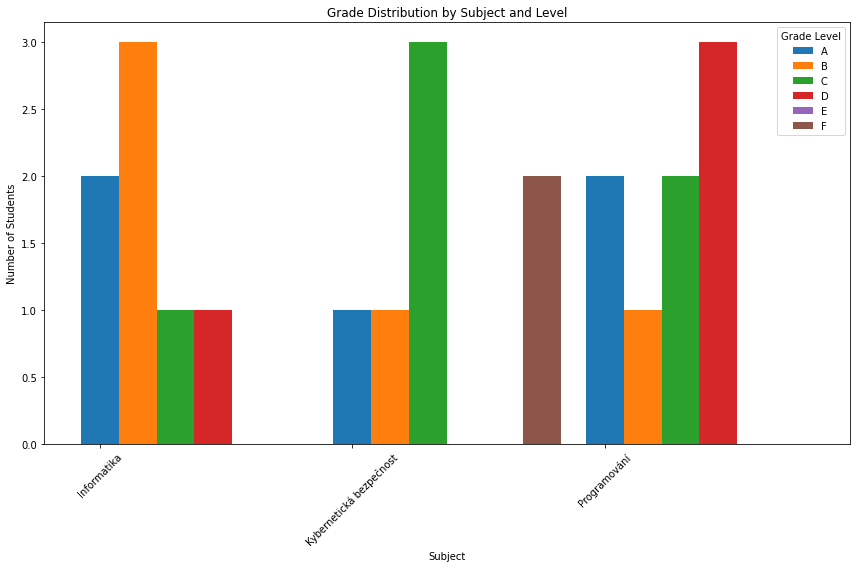

In [50]:
with open("result.json", "r", encoding='utf-8') as file:
    real_data = json.load(file)

with open("fake_data.json", "r", encoding='utf-8') as file:
    fake_data = json.load(file)

combined_data = real_data + fake_data

df = pd.DataFrame(combined_data)

grade_mapping = {"A": 1, "B": 1.5, "C": 2, "D": 2.5, "F": 3}
df["grade_value"] = df["level_name"].map(grade_mapping)

pivot_table = pd.pivot_table(df, 
                             values="grade_value", 
                             index="subject_name",
                             columns="level_name", 
                             aggfunc="count", 
                             fill_value=0)

pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

display(pivot_table)


import numpy as np 

# graph examle:
plt.figure(figsize=(12, 8))

# Define the width of each bar
bar_width = 0.15

# Define the positions for the bars
subjects = pivot_table.index
positions = np.arange(len(subjects))

# Plotting each level's bars for each subject
for i, level in enumerate(pivot_table.columns):
    plt.bar(positions + i * bar_width, pivot_table[level], width=bar_width, label=level)

plt.title("Grade Distribution by Subject and Level")
plt.xlabel("Subject")
plt.ylabel("Number of Students")
plt.xticks(positions + bar_width / 2, subjects, rotation=45)
plt.legend(title="Grade Level")
plt.tight_layout()
plt.show()